In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

prices = pd.read_csv("prices.txt", sep="\s+", header=None).T
nInst, nDays = prices.shape

def compute_rsi(prices, window=14):
    deltas = np.diff(prices)
    up = np.maximum(deltas, 0)
    down = -np.minimum(deltas, 0)
    avg_gain = pd.Series(up).rolling(window).mean()
    avg_loss = pd.Series(down).rolling(window).mean() + 1e-6
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.values

def compute_macd(price_series, fast=12, slow=26, signal=9):
    fast_ema = pd.Series(price_series).ewm(span=fast).mean()
    slow_ema = pd.Series(price_series).ewm(span=slow).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal).mean()
    return (macd_line - signal_line).values

def build_features_and_labels(prices, window=30, forecast_horizon=1):
    X = []
    y = []
    inst_idx = []

    for t in range(window, prices.shape[1] - forecast_horizon):
        cross_section = []
        for i in range(nInst):
            series = prices.iloc[i].values
            window_slice = series[t-window:t]
            if np.any(window_slice <= 0):
                continue
            rsi = compute_rsi(window_slice)[-1]
            macd_hist = compute_macd(window_slice)[-1]
            ret1 = (series[t] - series[t-1]) / (series[t-1] + 1e-6)
            ret5 = (series[t] - series[t-5]) / (series[t-5] + 1e-6)
            ret10 = (series[t] - series[t-10]) / (series[t-10] + 1e-6)
            vol5 = np.std(series[t-5:t])
            mom10 = series[t-1] - series[t-10]
            z = (series[t-1] - np.mean(series[t-10:t-1])) / (np.std(series[t-10:t-1]) + 1e-6)
            cross_section.append([i, ret1, ret5])

            future_return = (series[t+forecast_horizon] - series[t]) / (series[t] + 1e-6)
            X.append([
                series[t-1], np.mean(series[t-10:t]), np.std(series[t-10:t]),
                ret1, ret5, ret10, vol5, mom10, z, rsi, macd_hist
            ])
            y.append(future_return)
            inst_idx.append(i)

        cross_section = np.array(cross_section)
        if cross_section.size > 0:
            rank1 = cross_section[:,1].argsort().argsort() / (len(cross_section)-1)
            rank5 = cross_section[:,2].argsort().argsort() / (len(cross_section)-1)
            for j in range(len(rank1)):
                X[-(j+1)].extend([rank1[-(j+1)], rank5[-(j+1)]])

    return np.array(X), np.array(y), np.array(inst_idx)

X, y, inst_idx = build_features_and_labels(prices)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Score:", round(r2, 6))
print("Mean Squared Error:", round(mse, 6))
# hi


In [ ]:
import matplotlib.pyplot as plt

plt.barh(range(len(model.feature_importances_)), model.feature_importances_)
plt.yticks(range(len(X[0])), [
    "price_t-1", "mean_10", "std_10", "ret1", "ret5", "ret10",
    "vol5", "mom10", "zscore", "RSI", "MACD_hist", "rank_ret1", "rank_ret5"
])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
df = pd.DataFrame({"pred": y_pred, "actual": y_test})
df["bucket"] = pd.qcut(df["pred"], 10, labels=False)

grouped = df.groupby("bucket")["actual"].mean()
grouped.plot(kind="bar", title="Average Actual Return by Predicted Decile")

In [ ]:
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

prices = pd.read_csv("prices.txt", sep="\s+", header=None).T
nInst, nDays = prices.shape

def compute_rsi(prices, window=14):
    deltas = np.diff(prices)
    up = np.maximum(deltas, 0)
    down = -np.minimum(deltas, 0)
    avg_gain = pd.Series(up).rolling(window).mean()
    avg_loss = pd.Series(down).rolling(window).mean() + 1e-6
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.values

def compute_macd(price_series, fast=12, slow=26, signal=9):
    fast_ema = pd.Series(price_series).ewm(span=fast).mean()
    slow_ema = pd.Series(price_series).ewm(span=slow).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal).mean()
    return (macd_line - signal_line).values

def build_features_and_labels(prices, window=30, forecast_horizon=1):
    X = []
    y = []
    inst_idx = []

    for t in range(window, prices.shape[1] - forecast_horizon):
        features_t = []
        future_returns = []

        for i in range(prices.shape[0]):
            series = prices.iloc[i].values
            window_slice = series[t-window:t]

            if np.any(window_slice <= 0):
                features_t.append(None)
                future_returns.append(np.nan)
                continue

            rsi = compute_rsi(window_slice)[-1]
            macd_hist = compute_macd(window_slice)[-1]
            ret1 = (series[t] - series[t-1]) / (series[t-1] + 1e-6)
            ret5 = (series[t] - series[t-5]) / (series[t-5] + 1e-6)
            ret10 = (series[t] - series[t-10]) / (series[t-10] + 1e-6)
            vol5 = np.std(series[t-5:t])
            mom10 = series[t-1] - series[t-10]
            z = (series[t-1] - np.mean(series[t-10:t-1])) / (np.std(series[t-10:t-1]) + 1e-6)
            mean10 = np.mean(series[t-10:t])
            std10 = np.std(series[t-10:t])

            future_ret = (series[t + forecast_horizon] - series[t]) / (series[t] + 1e-6)
            future_returns.append(future_ret)

            features_t.append([
                series[t-1], mean10, std10,
                ret1, ret5, ret10, vol5, mom10, z, rsi, macd_hist
            ])

        future_returns = np.array(future_returns)
        valid_mask = ~np.isnan(future_returns)

        if np.sum(valid_mask) == 0:
            continue

        ranks = rankdata(future_returns[valid_mask]) / (np.sum(valid_mask) + 1e-6)

        for j, idx in enumerate(np.where(valid_mask)[0]):
            x_feats = features_t[idx]

            if x_feats is None:
                continue

            X.append(x_feats)
            y.append(ranks[j])
            inst_idx.append(idx)

    return np.array(X), np.array(y), np.array(inst_idx)

# Build data
X, y, inst_idx = build_features_and_labels(prices)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R² Score:", round(r2, 6))
print("Mean Squared Error:", round(mse, 6))

# Plot decile analysis
df = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
df["decile"] = pd.qcut(df["y_pred"], 10, labels=False)
grouped = df.groupby("decile")["y_test"].mean()

grouped.plot(kind="bar")
plt.title("Average Actual Ranked Return by Prediction Decile")
plt.ylabel("Mean Actual Rank (0=low, 1=high)")
plt.xlabel("Predicted Decile (Low to High)")
plt.grid()
plt.show()


In [1]:
import sys
!{sys.executable} -m pip install xgboost


  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


R² Score: -0.010277
Mean Squared Error: 0.084535


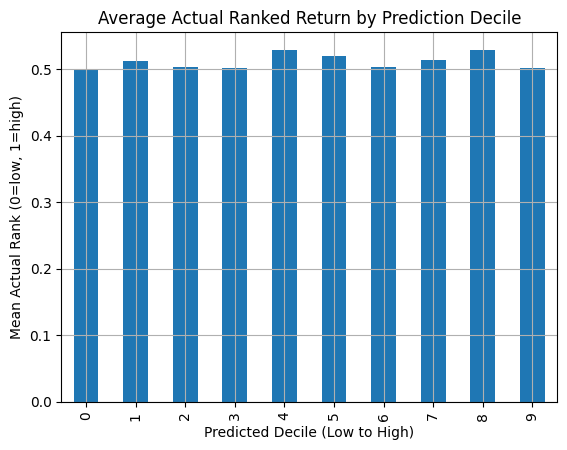

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

prices = pd.read_csv("prices.txt", sep="\s+", header=None).T
nInst, nDays = prices.shape

def compute_rsi(prices, window=14):
    deltas = np.diff(prices)
    up = np.maximum(deltas, 0)
    down = -np.minimum(deltas, 0)
    avg_gain = pd.Series(up).rolling(window).mean()
    avg_loss = pd.Series(down).rolling(window).mean() + 1e-6
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.values

def compute_macd(price_series, fast=12, slow=26, signal=9):
    fast_ema = pd.Series(price_series).ewm(span=fast).mean()
    slow_ema = pd.Series(price_series).ewm(span=slow).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal).mean()
    return (macd_line - signal_line).values

def build_features_and_labels(prices, window=30, forecast_horizon=1):
    X = []
    y = []
    inst_idx = []

    for t in range(window, prices.shape[1] - forecast_horizon):
        features_t = []
        future_returns = []

        for i in range(prices.shape[0]):
            series = prices.iloc[i].values
            window_slice = series[t-window:t]

            if np.any(window_slice <= 0):
                features_t.append(None)
                future_returns.append(np.nan)
                continue

            rsi = compute_rsi(window_slice)[-1]
            macd_hist = compute_macd(window_slice)[-1]
            ret1 = (series[t] - series[t-1]) / (series[t-1] + 1e-6)
            ret5 = (series[t] - series[t-5]) / (series[t-5] + 1e-6)
            ret10 = (series[t] - series[t-10]) / (series[t-10] + 1e-6)
            vol5 = np.std(series[t-5:t])
            mom10 = series[t-1] - series[t-10]
            z = (series[t-1] - np.mean(series[t-10:t-1])) / (np.std(series[t-10:t-1]) + 1e-6)
            mean10 = np.mean(series[t-10:t])
            std10 = np.std(series[t-10:t])

            future_ret = (series[t + forecast_horizon] - series[t]) / (series[t] + 1e-6)
            future_returns.append(future_ret)

            features_t.append([
                series[t-1], mean10, std10,
                ret1, ret5, ret10, vol5, mom10, z, rsi, macd_hist
            ])

        future_returns = np.array(future_returns)
        valid_mask = ~np.isnan(future_returns)

        if np.sum(valid_mask) == 0:
            continue

        ranks = rankdata(future_returns[valid_mask]) / (np.sum(valid_mask) + 1e-6)

        for j, idx in enumerate(np.where(valid_mask)[0]):
            x_feats = features_t[idx]

            if x_feats is None:
                continue

            X.append(x_feats)
            y.append(ranks[j])
            inst_idx.append(idx)

    return np.array(X), np.array(y), np.array(inst_idx)

# Build dataset
X, y, inst_idx = build_features_and_labels(prices)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R² Score:", round(r2, 6))
print("Mean Squared Error:", round(mse, 6))

# Decile bar plot
df = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
df["decile"] = pd.qcut(df["y_pred"], 10, labels=False)
grouped = df.groupby("decile")["y_test"].mean()

grouped.plot(kind="bar")
plt.title("Average Actual Ranked Return by Prediction Decile")
plt.ylabel("Mean Actual Rank (0=low, 1=high)")
plt.xlabel("Predicted Decile (Low to High)")
plt.grid()
plt.show()


R² Score: -0.012609
Mean Squared Error: 0.08473


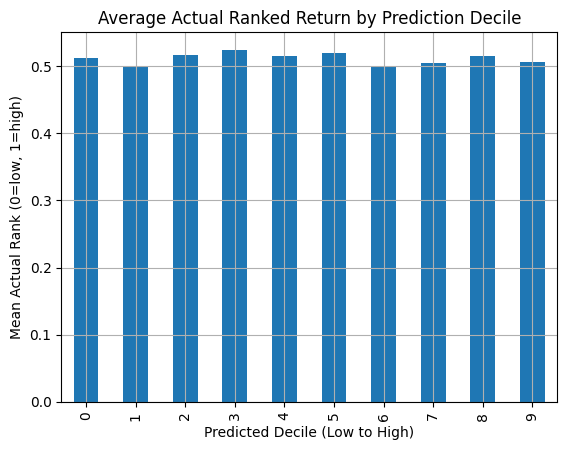

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, skew, kurtosis
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

prices = pd.read_csv("prices.txt", sep="\s+", header=None).T
nInst, nDays = prices.shape

def build_new_feature_set(prices, window=30, forecast_horizon=1):
    X = []
    y = []
    inst_idx = []

    for t in range(window, prices.shape[1] - forecast_horizon):
        features_t = []
        future_returns = []

        for i in range(prices.shape[0]):
            series = prices.iloc[i].values
            window_slice = series[t-window:t]

            if np.any(window_slice <= 0):
                features_t.append(None)
                future_returns.append(np.nan)
                continue

            # Returns
            ret1 = (series[t] - series[t-1]) / (series[t-1] + 1e-6)
            ret5 = (series[t] - series[t-5]) / (series[t-5] + 1e-6)

            # Volatility
            volatility_5 = np.std(series[t-5:t])

            # Momentum
            momentum_10 = series[t-1] - series[t-11]

            # Z-Score
            zscore_10 = (series[t-1] - np.mean(series[t-10:t])) / (np.std(series[t-10:t]) + 1e-6)

            # Skew & Kurtosis
            log_returns = np.diff(np.log(series[t-10:t]))
            skew_10 = skew(log_returns)
            kurt_10 = kurtosis(log_returns)

            # Mean-reversion signal: deviation from median
            mean_rev_signal = series[t-1] - np.median(series[t-5:t])

            # Append temporarily (without ranks yet)
            features_t.append([
                ret1, ret5, volatility_5, momentum_10, zscore_10,
                skew_10, kurt_10, mean_rev_signal
            ])

            # Target
            future_ret = (series[t + forecast_horizon] - series[t]) / (series[t] + 1e-6)
            future_returns.append(future_ret)

        future_returns = np.array(future_returns)
        valid_mask = ~np.isnan(future_returns)

        if np.sum(valid_mask) == 0:
            continue

        # Compute cross-sectional percentile ranks (normalized ranks)
        ret1s = np.array([x[0] if x is not None else np.nan for x in features_t])
        vol5s = np.array([x[2] if x is not None else np.nan for x in features_t])
        rank_ret1 = rankdata(ret1s[valid_mask]) / (np.sum(valid_mask) + 1e-6)
        rank_vol5 = rankdata(vol5s[valid_mask]) / (np.sum(valid_mask) + 1e-6)

        # Target is cross-sectional rank of future return
        y_ranked = rankdata(future_returns[valid_mask]) / (np.sum(valid_mask) + 1e-6)

        for j, idx in enumerate(np.where(valid_mask)[0]):
            x_feats = features_t[idx]
            if x_feats is None:
                continue
            x_feats_extended = x_feats + [rank_ret1[j], rank_vol5[j]]
            X.append(x_feats_extended)
            y.append(y_ranked[j])
            inst_idx.append(idx)

    return np.array(X), np.array(y), np.array(inst_idx)

# Build dataset
X, y, inst_idx = build_new_feature_set(prices)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R² Score:", round(r2, 6))
print("Mean Squared Error:", round(mse, 6))

# Decile bar plot
df = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
df["decile"] = pd.qcut(df["y_pred"], 10, labels=False)
grouped = df.groupby("decile")["y_test"].mean()

grouped.plot(kind="bar")
plt.title("Average Actual Ranked Return by Prediction Decile")
plt.ylabel("Mean Actual Rank (0=low, 1=high)")
plt.xlabel("Predicted Decile (Low to High)")
plt.grid()
plt.show()



===== Low Vol Instruments =====
R² Score: -0.021528
Mean Squared Error: 0.083643


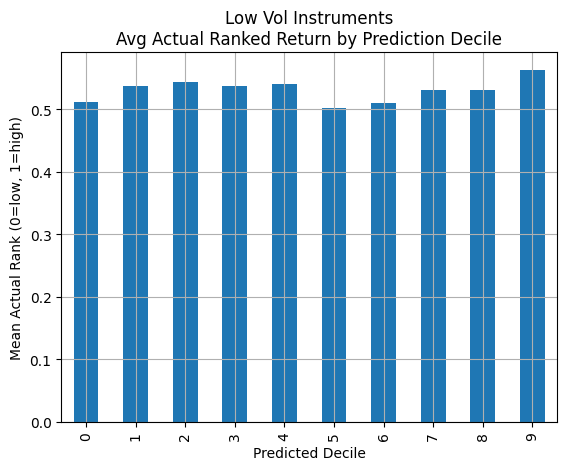


===== Med Vol Instruments =====
R² Score: -0.043095
Mean Squared Error: 0.085246


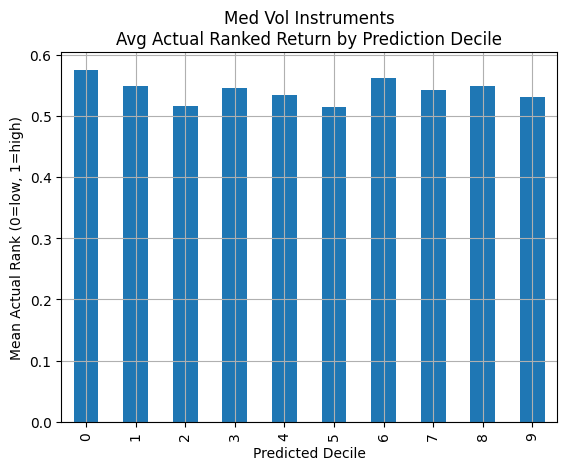


===== High Vol Instruments =====
R² Score: -0.027642
Mean Squared Error: 0.086153


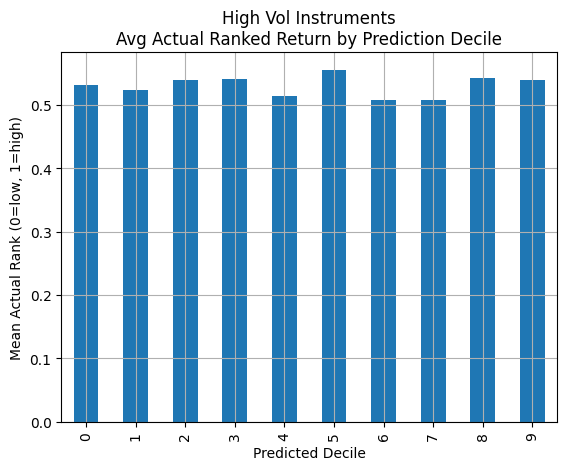

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, skew, kurtosis
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

prices = pd.read_csv("prices.txt", sep="\s+", header=None).T
nInst, nDays = prices.shape

# --- Group instruments by historical volatility ---
instrument_vols = prices.std(axis=1)
vol_thresholds = np.percentile(instrument_vols, [33.33, 66.67])

def get_volatility_group(vol):
    if vol < vol_thresholds[0]:
        return 'Low Vol'
    elif vol < vol_thresholds[1]:
        return 'Med Vol'
    else:
        return 'High Vol'

instrument_groups = [get_volatility_group(v) for v in instrument_vols]

# --- Feature builder reused for all groups ---
def build_features(prices, include_mask, window=30, forecast_horizon=1):
    X = []
    y = []
    inst_idx = []

    for t in range(window, prices.shape[1] - forecast_horizon):
        features_t = []
        future_returns = []

        for i in range(prices.shape[0]):
            if not include_mask[i]:
                features_t.append(None)
                future_returns.append(np.nan)
                continue

            series = prices.iloc[i].values
            window_slice = series[t-window:t]

            if np.any(window_slice <= 0):
                features_t.append(None)
                future_returns.append(np.nan)
                continue

            ret1 = (series[t] - series[t-1]) / (series[t-1] + 1e-6)
            ret5 = (series[t] - series[t-5]) / (series[t-5] + 1e-6)
            vol5 = np.std(series[t-5:t])
            momentum_10 = series[t-1] - series[t-11]
            zscore_10 = (series[t-1] - np.mean(series[t-10:t])) / (np.std(series[t-10:t]) + 1e-6)
            log_returns = np.diff(np.log(series[t-10:t]))
            skew_10 = skew(log_returns)
            kurt_10 = kurtosis(log_returns)
            mean_rev_signal = series[t-1] - np.median(series[t-5:t])

            future_ret = (series[t + forecast_horizon] - series[t]) / (series[t] + 1e-6)
            features_t.append([
                ret1, ret5, vol5, momentum_10, zscore_10,
                skew_10, kurt_10, mean_rev_signal
            ])
            future_returns.append(future_ret)

        future_returns = np.array(future_returns)
        valid_mask = ~np.isnan(future_returns)

        if np.sum(valid_mask) == 0:
            continue

        ret1s = np.array([x[0] if x is not None else np.nan for x in features_t])
        vol5s = np.array([x[2] if x is not None else np.nan for x in features_t])
        rank_ret1 = rankdata(ret1s[valid_mask]) / (np.sum(valid_mask) + 1e-6)
        rank_vol5 = rankdata(vol5s[valid_mask]) / (np.sum(valid_mask) + 1e-6)
        y_ranked = rankdata(future_returns[valid_mask]) / (np.sum(valid_mask) + 1e-6)

        for j, idx in enumerate(np.where(valid_mask)[0]):
            x_feats = features_t[idx]
            if x_feats is None:
                continue
            x_feats_extended = x_feats + [rank_ret1[j], rank_vol5[j]]
            X.append(x_feats_extended)
            y.append(y_ranked[j])
            inst_idx.append(idx)

    return np.array(X), np.array(y), np.array(inst_idx)

# --- Train and evaluate per group ---
for group_name in ['Low Vol', 'Med Vol', 'High Vol']:
    print(f"\n===== {group_name} Instruments =====")
    include_mask = [g == group_name for g in instrument_groups]
    
    X, y, inst_idx = build_features(prices, include_mask)

    if len(X) == 0:
        print("No data for this group.")
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("R² Score:", round(r2, 6))
    print("Mean Squared Error:", round(mse, 6))

    df = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
    df["decile"] = pd.qcut(df["y_pred"], 10, labels=False)
    grouped = df.groupby("decile")["y_test"].mean()

    grouped.plot(kind="bar")
    plt.title(f"{group_name} Instruments\nAvg Actual Ranked Return by Prediction Decile")
    plt.ylabel("Mean Actual Rank (0=low, 1=high)")
    plt.xlabel("Predicted Decile")
    plt.grid()
    plt.show()
